In [42]:
import numpy as np
from math import isnan
import threading as trd
import math
import random as rnd

    

#def estimate_gaussian(data):
 #   return np.mean(data),np.cov(data)
    
    
def info_gain(data,cov,data_l,cov_l,data_r,cov_r):
    
    a=np.linalg.det(cov)
    if(isnan(a)==True):
        a=0.000000000000000000001
    a=np.log(abs(a))
    
    
    b=np.linalg.det(cov_l)
    if np.isnan(b)==True:
        b=0.000000000000000000001
    #print(data_l.shape[1])
    b=(data_l.shape[0]/data.shape[0]) * np.log(abs(b))
    
    
    c=np.linalg.det(cov_r)
    if np.isnan(c)==True:
        c=0.000000000000000000001
    c=(data_r.shape[0]/data.shape[0]) * np.log(abs(c))
    
    
    print('b: '+str(b) +' shape: '+str(data_l.shape))
    print('c: '+str(c) +' shape: '+str(data_r.shape))
    print('infogain: '+str(a-b-c))
    return a-b-c
    
def split_data(data,split,direction):
#    print('hi')
    left_data=np.array([[0,0]])
    right_data=np.array([[0,0]])
    for d in range(data.shape[0]):
        if data[d][direction]<=split:
            left_data=np.append(left_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
        else:
            #print(1,left_data[d].shape[0])
            right_data=np.append(right_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
   # print(left_data)
    left_data=np.delete(left_data,0,axis=0)
    right_data=np.delete(right_data,0,axis=0)
    return(left_data,right_data)
            

class RandomDensityTree:

    def __init__(self,max_depth=10,num_splits=10,min_infogain=1.5):
        self.max_depth = max_depth
        #self.root=data
        tree=[]
        for i in range(30):
            tree.append(0)
        self.tree=tree
        self.min_infogain=min_infogain
        self.num_splits=num_splits
        
    def fit(self,data):
        self.root=data
        self.mean = np.mean(data,axis=0)
        self.cov=np.cov(np.transpose(data))
        self.rootnode=Node(data,self.cov,[],self.tree,num_splits=self.num_splits,min_infogain=self.min_infogain,max_depth=self.max_depth,pointer=0)
        self.tree[0]=self.rootnode
        print(self.rootnode.get_results())

    def predict(self,points):
        new=[]
        for p in points:
            new.append(rootnode.predict(p))
        return new
    
    def max_prob():
        return rootnode.maxprob()
    #def extend():
     #   np.concatenate([self.tree,np.zeros(30)],axis=0)
    def get_results(self):
    #    print(self.tree)
    #    print(self.root)
        return self.rootnode.get_results()
    def leafnodes(self):
        return self.rootnode.leafnodes()
    
class Node:
    
    def __init__(self,data,cov,history,tree,num_splits,min_infogain,max_depth,pointer):
        #self.min_infgain=min_infgain
        self.maxdepth=max_depth
        self.min_infogain=min_infogain
        self.pointer=pointer
        
        self.tree=tree
        self.num_splits=num_splits
    #    tree[pointer]={''}
        
        self.history=history
        self.root=data
        self.mean=np.mean(data,axis=0)
        self.cov=cov
        self.isLeaf=False
        if(max_depth==0 or data.shape[1]==1):
            self.isLeaf=True
        else:
            rnd_splits=[]
            for dim in range(int(num_splits)):
                direction=rnd.choice([0,1])
                rnd_split=rnd.uniform(min(data[:,direction]),max(data[:,direction]))
                rnd_splits.append({'split':rnd_split,'direction':direction})

            left_datas=[]
            info_gains=[]
            right_datas=[]

            covs_left=[]
            covs_right=[]

            for s in range(len(rnd_splits)):#or the number of random splits
                
                left_data,right_data=split_data(data,rnd_splits[s]['split'],rnd_splits[s]['direction'])
                if(left_data.shape[0]>2 and right_data.shape[0]>2):

                   # left_data=[] #data left of the split
                   # right_data=[] #data right of the split
                    #for a in data:
                     #   if a <= splits[d]:
                      #      left_data.append(a)
                       # else:
                        #    right_data.append(a)
                    right_data

                    right_datas.append(right_data)
                    left_datas.append(left_data)

                    cov_l=np.cov(np.transpose(left_data))
                    cov_r=np.cov(np.transpose(right_data))

                    covs_left.append(cov_l)
                    covs_right.append(cov_r)
                 #   print(left_data)
                    info_gains.append(info_gain(data,self.cov,left_data,cov_l,right_data,cov_r)) #entropies of left and right data)
                    #information gain if this split is used
            if len(info_gains)==0:
                self.isleaf=True
            else:
                best=np.argmax(info_gains)
                print('best infogain: '+str(info_gains[best]))
                print(min_infogain)
                if info_gains[best] >= min_infogain:
                    print('ho')
                    self.split=rnd_splits[best]['split']   #best split
                    self.split_dim=rnd_splits[best]['direction'] 
                    history.append(rnd_splits[best])
                    if(2*pointer+2>=len(tree)):
                        for i in range((2*pointer+2)-len(tree)+1):
                            tree.append(0)
                   # print(left_datas[best].shape)
                    #print(right_datas[best].shape)
                    #print((left_datas[best],covs_left[best],history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1))
                    leftnode=Node(left_datas[best],covs_left[best],history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1)
                    tree[2*pointer+1]=leftnode
                    self.left_child=leftnode
                   # print(len(right_datas[best],covs_right[best],history,self.num_splits,self.min_infogain,s2))
                    rightnode=Node(right_datas[best],covs_right[best],history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+2)
                    tree[2*pointer+2]=rightnode
                    self.right_child=rightnode
                    print('hi')
                else:
                    self.isLeaf=True
                                  
    def predict(point):
        if isLeaf==True:
            return self.pointer
        else:
            if point[split_dim]>=split:
                return self.left_child.predict(point)
            else:
                return self.right_child.predict(point)
            
    def get_results(self):
        if(self.isLeaf==True):
            return {'mean':self.mean,'cov':self.cov}
            print('whoa')
        else:
            return [{'split':self.split,'split_dim':self.split_dim,},{'left_child':self.left_child.get_results()},{'right_child':self.right_child.get_results()}]
   
    def maxprob():
        return 1
    
    def leafnodes(self):
        if self.isLeaf == True:
            return 1
        else:
            return left_child.leafnodes()+right_child.lefnodes()
        
    
def partition_function(tree, x):
    # generate a lot of samples in the bounds of the data and the size of the bounded shape
    samples, b_size = generate_monte_carlo_sample(x)
    # add gaussian probability dimension for those samples
  #  g_probs_samples = np.random.random(len(samples))*tree.max_prob
  #  b_size = b_size*tree.max_prob
    # predict the target leaf nodes for all samples
    leaf_node_ids = tree.predict(samples)
    # compute the distribution integral over each leaf node
    g_ints = np.zeros((len(tree.leaf_nodes),))
    for ln_id in range(len(tree.leaf_nodes)):
        leaf_node = tree.leaf_nodes[ln_id]
        mean_vec = leaf_node.mean
        cov_mat = leaf_node.cov
        mnd = stats.multivariate_normal(mean_vec, cov_mat)
        sample_id_mask = leaf_node_ids==ln_id
        g_probs = mnd(samples[sample_id_mask])
        g_cnt = np.sum(g_probs_samples<=g_probs)
        g_ints[ln_id] = g_cnt/len(samples)*b_size
    
    
'''
class RandomDensityForest:
    def _init(self,max_length=10,num_trees=10):
        self.max_length=max_length
        self.num_trees=num_trees
        
    def train_and_stuff(data):
        #lauch DensityTrees
        #train on data
        #return results
        #use partition function
        #combine them into final result
    
    I= entropy - sum
theta= max(I)    
'''

'\nclass RandomDensityForest:\n    def _init(self,max_length=10,num_trees=10):\n        self.max_length=max_length\n        self.num_trees=num_trees\n        \n    def train_and_stuff(data):\n        #lauch DensityTrees\n        #train on data\n        #return results\n        #use partition function\n        #combine them into final result\n    \n    I= entropy - sum\ntheta= max(I)    \n'

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

data = np.zeros([100,2])
for i in range(30):
    data[i]=np.random.normal([2,2],0.5)
   # data[i][0]=np.random.normal(2,0.5)[0]
    #data[i][1]=np.random.normal(2)[1]
for i in range(30):
    data[30+i]=np.random.normal([5,5],0.5)
    #data[30+i][1]=np.random.normal(5,0.5) 
for i in range(30):
    data[60+i]=np.random.normal([5,1],0.5)
   
for i in range(10):
    data[90+i]=np.random.normal([1,5],0.5)


DensityTree=RandomDensityTree()
DensityTree.fit(data)

b: -0.241049562626 shape: (40, 2)
c: -0.0983643229771 shape: (60, 2)
infogain: 2.64737891416
b: -0.241049562626 shape: (40, 2)
c: -0.0983643229771 shape: (60, 2)
infogain: 2.64737891416
b: -0.223044890962 shape: (55, 2)
c: 0.381060947059 shape: (45, 2)
infogain: 2.14994897246
b: -0.241049562626 shape: (40, 2)
c: -0.0983643229771 shape: (60, 2)
infogain: 2.64737891416
b: -0.30742351077 shape: (37, 2)
c: 0.315141535534 shape: (63, 2)
infogain: 2.30024700379
b: 0.641531945309 shape: (66, 2)
c: -0.21623925439 shape: (34, 2)
infogain: 1.88267233763
b: -0.187101773393 shape: (60, 2)
c: -0.108281436986 shape: (40, 2)
infogain: 2.60334823893
b: 2.06474720651 shape: (91, 2)
c: -0.375511100153 shape: (9, 2)
infogain: 0.618728922199
b: 0.955973491726 shape: (57, 2)
c: -0.528031286374 shape: (43, 2)
infogain: 1.8800228232
b: 1.62863836231 shape: (76, 2)
c: -0.435276771808 shape: (24, 2)
infogain: 1.11460343804
best infogain: 2.64737891416
1.5
ho
b: -1.8409360574 shape: (22, 2)
c: -0.569386644604 s

AttributeError: 'Node' object has no attribute 'split'

In [139]:
print(DensityTree.get_results())

{'split_dim': 0, 'right_child': {'mean': array([ 5.61104712,  3.33917795]), 'cov': array([[ 0.05861008, -0.10977966],
       [-0.10977966,  4.20947606]])}, 'left_child': {'split_dim': 1, 'right_child': {'mean': array([ 3.06688524,  4.01174777]), 'cov': array([[ 2.75374583,  0.85447495],
       [ 0.85447495,  1.52033141]])}, 'left_child': {'mean': array([ 3.67059385,  1.22129618]), 'cov': array([[ 2.09713977, -0.57117598],
       [-0.57117598,  0.29296278]])}, 'split': 2.0341059587345365}, 'split': 5.3057299996204339}


[[ 1.54522355  2.44281437]
 [ 2.76935626  2.19872177]
 [ 2.37517476  2.21219694]
 [ 1.78402426  2.23568741]
 [ 2.78288774  1.81449817]
 [ 2.61052336  1.10327395]
 [ 2.10583558  1.58854849]
 [ 1.14327408  1.62307423]
 [ 2.62642548  1.97346943]
 [ 1.86955814  2.76686479]
 [ 2.99299655  2.80692906]
 [ 2.22252609  2.25886317]
 [ 1.58046368  2.43282558]
 [ 2.59818799  1.61270352]
 [ 1.3976586   2.72553455]
 [ 2.46890808  1.80654115]
 [ 1.78582437  2.34486117]
 [ 1.7005475   2.2396796 ]
 [ 2.29688195  2.06766295]
 [ 1.44534566  2.0533586 ]
 [ 1.68764966  2.45716577]
 [ 2.13825756  2.74260885]
 [ 1.88788117  1.48420346]
 [ 2.3441589   1.13591042]
 [ 2.85955117  2.12448798]
 [ 1.23460057  1.17397426]
 [ 1.67589488  1.67993882]
 [ 2.29206102  2.43001336]
 [ 2.30780717  2.32163076]
 [ 2.20061305  2.2790915 ]
 [ 5.0907229   5.21278781]
 [ 4.95253657  5.55087465]
 [ 5.40157906  4.18178059]
 [ 4.61096878  5.25578752]
 [ 5.61555544  4.92660126]
 [ 4.82067327  4.54110437]
 [ 5.28560921  6.36666922]
 

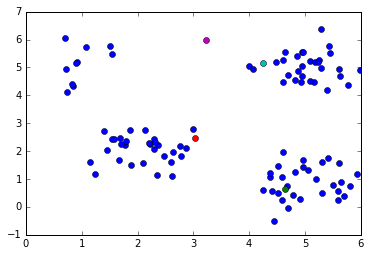

In [8]:
print(data)
plt.plot(data[:,0],data[:,1], "o")
plt.plot( 4.64157772,  0.63988413,"o")
plt.plot( 3.03334449,  2.46542821,"o")
plt.plot( 4.24936537,  5.14213751,"o")
plt.plot( 3.23164995,  5.9834305 ,"o")

In [125]:
data2 = np.zeros([100,2])
for i in range(100):
    data2[i]=np.random.normal([2,2],1)
    
print(np.linalg.det(np.cov(np.transpose(data2))))

0.667861415361


In [19]:
print(np.log(-1))

nan


c:\program files\python35\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
